In [2]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import numpy as np

In [3]:
test_data = MNIST(
    root="/data/DataSet/",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.5),
            std=(0.5)
        )
    ])
)
train_data = MNIST(
    root="/data/DataSet/",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.5),
            std=(0.5)
        )
    ])
)

In [4]:
labels_map = train_data.class_to_idx
labels_map = dict(zip(labels_map.values(), labels_map.keys()))

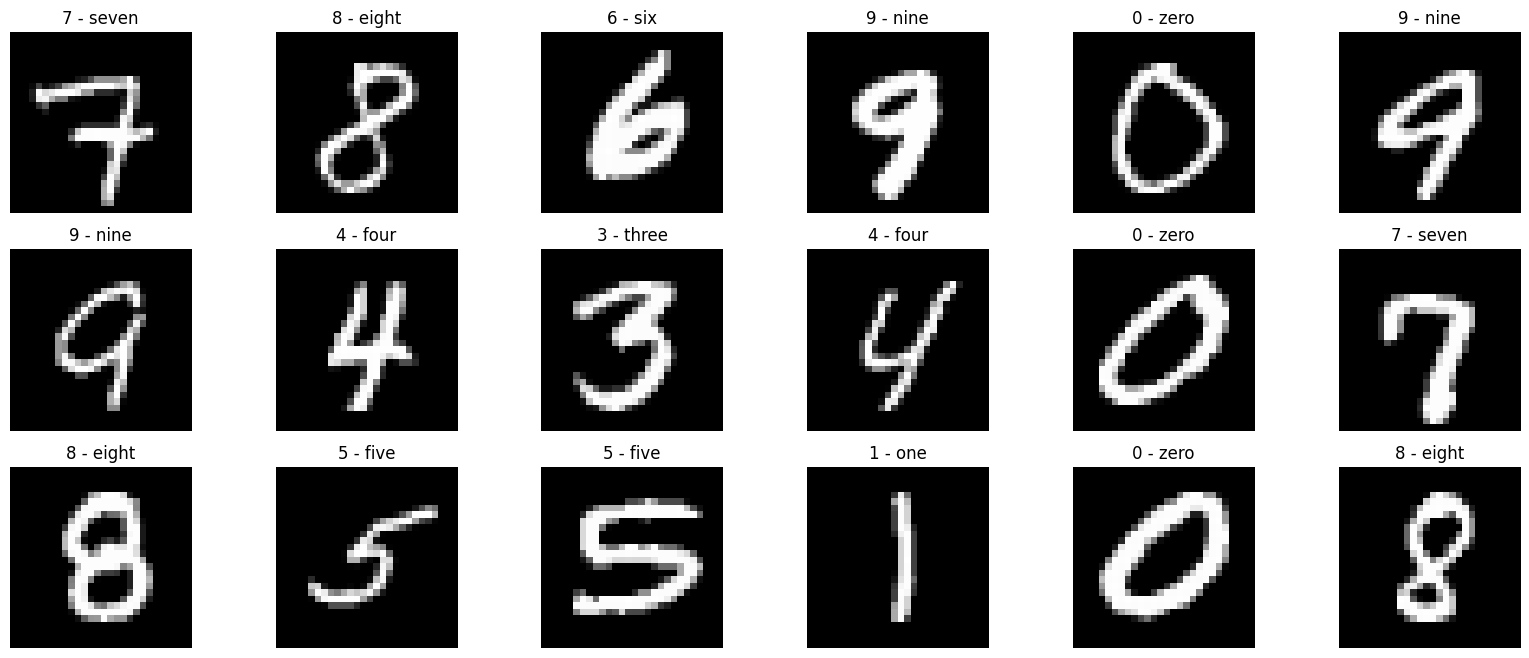

In [5]:
fig = plt.figure(figsize=(20, 8))

col = 6
row = 3

for i in range(1, col * row + 1):
    random_img_number = np.random.randint(len(train_data))
    random_img = train_data[random_img_number][0][0]

    fig.add_subplot(row, col, i)
    plt.title(labels_map[train_data[random_img_number][1]])
    plt.axis('off')
    plt.imshow(random_img, cmap='gray')

plt.show()

In [6]:
from torch import normal


class down(nn.Module):
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int, 
        kernel_size: int = 4, 
        stride: int = 2, 
        padding: int = 1,
        normalize: bool = True,
        activation: bool = True,
        dropout: float = 0.0
        ):

        layers = [
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
            )
        ]
        
        if normalize:
            layers.append(
                nn.BatchNorm2d(
                    num_features=out_channels
                )
            )
        
        if activation:
            layers.append(
                nn.ReLU()
            )

        if dropout:
            layers.append(
                nn.Dropout(
                    p=dropout
                )
            )
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)
        
class CNN(nn.Module):
    def __init__(self, in_channels: int = 1, out_channels: int = 1):
        super(CNN, self).__init__()
        
        # 28 -> 14
        self.layer1 = down(
            in_channels=in_channels,
            out_channels=64,
            dropout=0.3
        )
        
        # 14 -> 8
        self.layer2 = down(
            in_channels=64,
            out_channels=128,
            kernel_size=2,
            stride=2,
            padding=1,
            dropout=0.3
        )

        # 8 -> 4
        self.layer3 = down(
            in_channels=128,
            out_channels=256,
            dropout=0.3
        )

        # 4 -> 2
        self.layer4 = down(
            in_channels=256,
            out_channels=512,
            dropout=0.3
        )

        # 2 -> 1
        self.layer5 = down(
            in_channels=512,
            out_channels=1024,
            normal=False,
            ac
        )


SyntaxError: positional argument follows keyword argument (750541000.py, line 91)